# March Mania 2025 - Starter Notebook

## Goal of the competition

The goal of this competition is to predict that probability that the smaller ``TeamID`` will win a given matchup. You will predict the probability for every possible matchup between every possible team over the past 4 years. You'll be given a sample submission file where the ```ID``` value indicates the year of the matchup as well as the identities of both teams within the matchup. For example, for an ```ID``` of ```2025_1101_1104``` you would need to predict the outcome of the matchup between ```TeamID 1101``` vs ```TeamID 1104``` during the ```2025``` tournament. Submitting a ```PRED``` of ```0.75``` indicates that you think that the probability of ```TeamID 1101``` winning that particular matchup is equal to ```0.75```.


## Overview of our submission strategy 
For this starter notebook, we will make a simple submission.

We can predict the winner of a match by considering the respective rankings of the opposing teams, only. Since the largest possible difference is 15 (which is #16 minus #1), we use a rudimentary formula that's 0.5 plus 0.03 times the difference in seeds, leading to a range of predictions spanning from 5% up to 95%. The stronger-seeded team (with a lower seed number from 1 to 16) will be the favorite and will have a prediction above 50%. 

# Starter Code

## Step 1: Import Python packages and load the data

In [215]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.3, palette='Set2')
%matplotlib inline

In [216]:
#!pip install kaggle
#!kaggle competitions download -c march-machine-learning-mania-2025

In [217]:
import zipfile

zip_file_path = 'march-machine-learning-mania-2025.zip'
extract_dir = './data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## Step 2: Explore the data

### Section 1: base data

In [218]:
w_team = pd.read_csv('data/WTeams.csv')
m_team = pd.read_csv('data/MTeams.csv')
w_team.head()

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M


Later on we can add team name to the data, but for now we will just look at the team ID.

In [219]:
w_season = pd.read_csv('data/WSeasons.csv')
m_season = pd.read_csv('data/MSeasons.csv')

In [220]:
w_seed = pd.read_csv('data/WNCAATourneySeeds.csv')
m_seed = pd.read_csv('data/MNCAATourneySeeds.csv')

In [221]:
w_season.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1998,10/27/1997,East,Midwest,Mideast,West
1,1999,10/26/1998,East,Mideast,Midwest,West
2,2000,11/01/1999,East,Midwest,Mideast,West
3,2001,10/30/2000,East,Midwest,Mideast,West
4,2002,10/29/2001,East,West,Mideast,Midwest


In [222]:
m_tourney_results = pd.read_csv('data/MNCAATourneyCompactResults.csv')
w_tourney_results = pd.read_csv('data/WNCAATourneyCompactResults.csv')
m_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


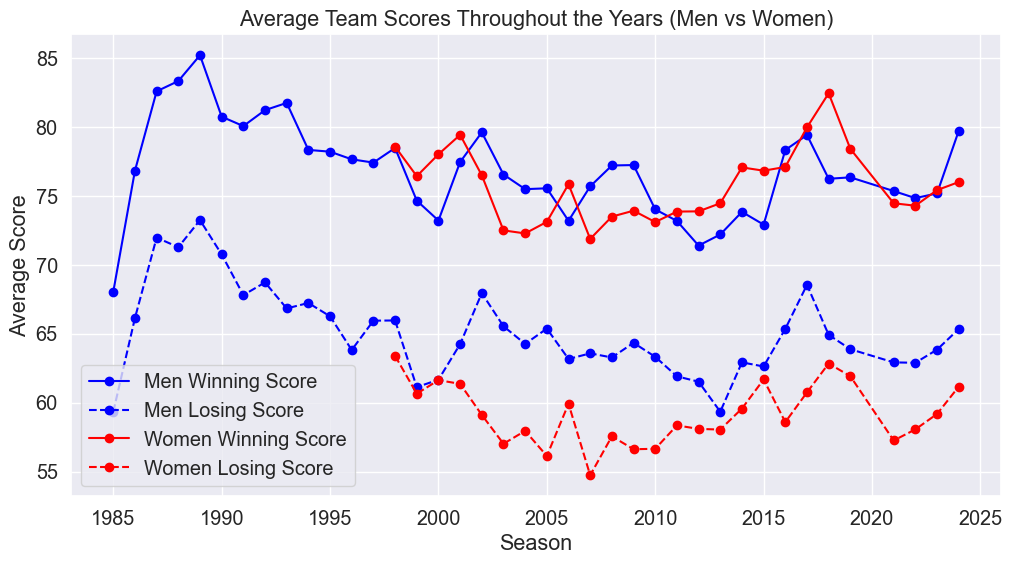

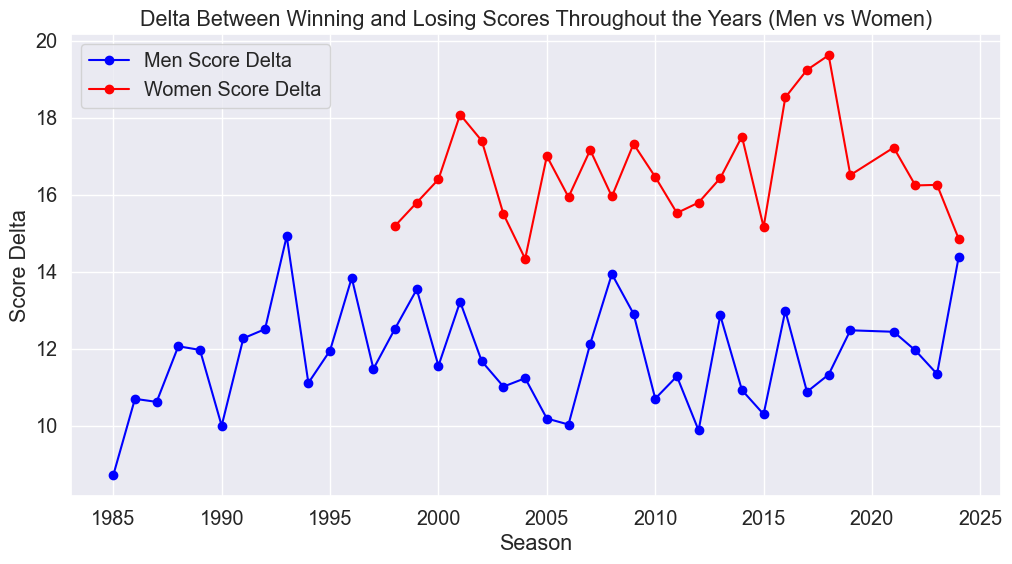

In [223]:
# Group by season and calculate the average scores for men's tournament
avg_scores_men = m_tourney_results.groupby('Season')[['WScore', 'LScore']].mean()

# Group by season and calculate the average scores for women's tournament
avg_scores_women = w_tourney_results.groupby('Season')[['WScore', 'LScore']].mean()

# Plot the average scores for both men's and women's tournaments
plt.figure(figsize=(12, 6))
plt.plot(avg_scores_men.index, avg_scores_men['WScore'], marker='o', linestyle='-', color='b', label='Men Winning Score')
plt.plot(avg_scores_men.index, avg_scores_men['LScore'], marker='o', linestyle='--', color='b', label='Men Losing Score')
plt.plot(avg_scores_women.index, avg_scores_women['WScore'], marker='o', linestyle='-', color='r', label='Women Winning Score')
plt.plot(avg_scores_women.index, avg_scores_women['LScore'], marker='o', linestyle='--', color='r', label='Women Losing Score')
plt.title('Average Team Scores Throughout the Years (Men vs Women)')
plt.xlabel('Season')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the delta between winning and losing scores for both men's and women's tournaments
avg_scores_men['Delta'] = avg_scores_men['WScore'] - avg_scores_men['LScore']
avg_scores_women['Delta'] = avg_scores_women['WScore'] - avg_scores_women['LScore']

# Plot the delta scores for both men's and women's tournaments
plt.figure(figsize=(12, 6))
plt.plot(avg_scores_men.index, avg_scores_men['Delta'], marker='o', linestyle='-', color='b', label='Men Score Delta')
plt.plot(avg_scores_women.index, avg_scores_women['Delta'], marker='o', linestyle='-', color='r', label='Women Score Delta')
plt.title('Delta Between Winning and Losing Scores Throughout the Years (Men vs Women)')
plt.xlabel('Season')
plt.ylabel('Score Delta')
plt.legend()
plt.grid(True)
plt.show()

## Team features

Lets generate a dataset for team at 2024 season and try to predict the 2024 NCAA games

In [224]:
m_teams = pd.read_csv('data/MTeams.csv')
w_teams = pd.read_csv('data/WTeams.csv')
m_teams['gender'] = 'M'
w_teams['gender'] = 'W'

Now lets create a separate record for each season of each team

In [225]:
# Create a separate record for each year for women teams since 1998
w_teams_expanded = w_teams.loc[w_teams.index.repeat(2025 - 1998 + 1)]
w_teams_expanded['Season'] = w_teams.apply(lambda row: list(range(1998, 2025 + 1)), axis=1).explode().values

# Create a separate record for each year for men teams for every season the team is in D1
m_teams_expanded = m_teams.loc[m_teams.index.repeat(m_teams['LastD1Season'] - m_teams['FirstD1Season'] + 1)]
m_teams_expanded['Season'] = m_teams.apply(lambda row: list(range(row['FirstD1Season'], row['LastD1Season'] + 1)), axis=1).explode().values

# Combine the expanded dataframes
teams_expanded = pd.concat([m_teams_expanded, w_teams_expanded], axis=0)
teams_expanded.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,gender,Season
0,1101,Abilene Chr,2014.0,2025.0,M,2014
0,1101,Abilene Chr,2014.0,2025.0,M,2015
0,1101,Abilene Chr,2014.0,2025.0,M,2016
0,1101,Abilene Chr,2014.0,2025.0,M,2017
0,1101,Abilene Chr,2014.0,2025.0,M,2018


Check if the data is correct

In [226]:
def check_correctness(data, columns):
    unique_cnt = data[columns].drop_duplicates().shape[0]
    total = len(data)
    assert unique_cnt == total, f'Error: unique_cnt:{unique_cnt} != total:{total}'
    print('All good!')

In [227]:
unique_triples_count = teams_expanded[['gender', 'Season', 'TeamName']].drop_duplicates().shape[0]
assert unique_triples_count == len(teams_expanded)

### Add the seed data

In [228]:
m_seed = pd.read_csv('data/MNCAATourneySeeds.csv')
w_seed = pd.read_csv('data/WNCAATourneySeeds.csv')

seed_df = pd.concat([m_seed, w_seed], axis=0)
seed_df.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Extract the region and seed value from the seed data

In [229]:
seed_df['Region'] = seed_df['Seed'].apply(lambda x: x[0])
seed_df['Seed_num'] = seed_df['Seed'].apply(lambda x: int(x[1:3]))
seed_df.head()

,Season,Seed,TeamID,Region,Seed_num
0,1985,W01,1207,W,1
1,1985,W02,1210,W,2
2,1985,W03,1228,W,3
3,1985,W04,1260,W,4
4,1985,W05,1374,W,5


In [230]:
# Merge seed with teams dataframe
teams_expanded = pd.merge(seed_df, teams_expanded, on=('TeamID', 'Season'), how='inner')
teams_expanded.head()


,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender
0,1985,W01,1207,W,1,Georgetown,1985.0,2025.0,M
1,1985,W02,1210,W,2,Georgia Tech,1985.0,2025.0,M
2,1985,W03,1228,W,3,Illinois,1985.0,2025.0,M
3,1985,W04,1260,W,4,Loyola-Chicago,1985.0,2025.0,M
4,1985,W05,1374,W,5,SMU,1985.0,2025.0,M


### Add features corresponding to the regular season performance

In [231]:
m_regular_season_results = pd.read_csv('data/MRegularSeasonCompactResults.csv')
w_regular_season_results = pd.read_csv('data/WRegularSeasonCompactResults.csv')

regular_season_results = pd.concat([m_regular_season_results, w_regular_season_results], axis=0)
regular_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [232]:
# Calculate average points difference for each team for each season
regular_season_results['PointsDiff'] = regular_season_results['WScore'] - regular_season_results['LScore']

points_diff_win = regular_season_results[['Season', 'WTeamID', 'PointsDiff']]
points_diff_win.columns = ['Season', 'TeamID', 'PointsDiff']

points_diff_lose = regular_season_results[['Season', 'LTeamID', 'PointsDiff']]
points_diff_lose['PointsDiff'] = -points_diff_lose['PointsDiff']
points_diff_lose.columns = ['Season', 'TeamID', 'PointsDiff']

point_diff_total = pd.concat([points_diff_win, points_diff_lose], axis=0)

point_diff_total['WinFlag'] = (point_diff_total['PointsDiff'] > 0).astype(int)

avg_stats = point_diff_total.groupby(by=['TeamID', 'Season'])[['PointsDiff', 'WinFlag']].mean().reset_index()
avg_stats.columns = ['TeamID', 'Season', 'AvgPointsDiff', 'WinRate']

# Merge with teams dataframe
teams_expanded_2 = pd.merge(teams_expanded, avg_stats, on=('TeamID', 'Season'), how='left')


teams_expanded_2.head()

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/4040964570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points_diff_lose['PointsDiff'] = -points_diff_lose['PointsDiff']


,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender,AvgPointsDiff,WinRate
0,1985,W01,1207,W,1,Georgetown,1985.0,2025.0,M,15.666667,0.925926
1,1985,W02,1210,W,2,Georgia Tech,1985.0,2025.0,M,9.354839,0.774194
2,1985,W03,1228,W,3,Illinois,1985.0,2025.0,M,10.870968,0.741935
3,1985,W04,1260,W,4,Loyola-Chicago,1985.0,2025.0,M,6.766667,0.833333
4,1985,W05,1374,W,5,SMU,1985.0,2025.0,M,8.666667,0.733333


In [233]:
teams_expanded_2.query('Season == 2024')

,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender,AvgPointsDiff,WinRate
2490,2024,W01,1163,W,1,Connecticut,1985.0,2025.0,M,17.058824,0.911765
2491,2024,W02,1235,W,2,Iowa St,1985.0,2025.0,M,14.264706,0.794118
2492,2024,W03,1228,W,3,Illinois,1985.0,2025.0,M,10.617647,0.764706
2493,2024,W04,1120,W,4,Auburn,1985.0,2025.0,M,15.294118,0.794118
2494,2024,W05,1361,W,5,San Diego St,1985.0,2025.0,M,6.843750,0.687500
...,...,...,...,...,...,...,...,...,...,...,...
4297,2024,Z12b,3435,Z,12,Vanderbilt,NaN,NaN,W,6.967742,0.709677
4298,2024,Z13,3267,Z,13,Marshall,NaN,NaN,W,12.100000,0.800000
4299,2024,Z14,3238,Z,14,Jackson St,NaN,NaN,W,10.379310,0.793103
4300,2024,Z15,3263,Z,15,Maine,NaN,NaN,W,7.969697,0.727273


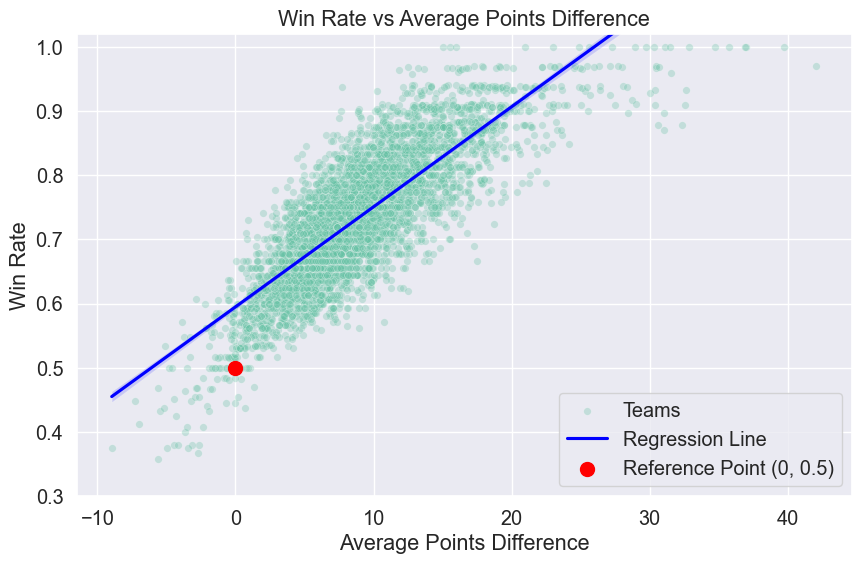

In [234]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=teams_expanded_2, x='AvgPointsDiff', y='WinRate', s=30, alpha = 0.3, label='Teams')
sns.regplot(data=teams_expanded_2, x='AvgPointsDiff', y='WinRate', scatter=False, color='blue', label='Regression Line')
plt.scatter(0, 0.5, color='red', s=100, zorder=5, label='Reference Point (0, 0.5)')
plt.title('Win Rate vs Average Points Difference')
plt.xlabel('Average Points Difference')
plt.ylabel('Win Rate')
plt.ylim(0.3, 1.02)
plt.legend()
plt.grid(True)
plt.show()

### Add public rankings data for men's basketball

In [235]:
m_public_rankings = pd.read_csv('data/MMasseyOrdinals.csv')
m_public_rankings.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [236]:
latest_rankings = m_public_rankings.sort_values('RankingDayNum', ascending=True).drop_duplicates(['Season', 'TeamID'], keep='last')
latest_rankings = latest_rankings[['Season', 'TeamID', 'OrdinalRank', 'SystemName']]
latest_rankings.columns = ['Season', 'TeamID', 'PublicRank', 'RankingSystem']


In [237]:
check_correctness(latest_rankings, ['Season', 'TeamID', 'PublicRank'])

All good!


In [238]:
teams_expanded_3 = pd.merge(teams_expanded_2, latest_rankings, on=('Season', 'TeamID'), how='left')
teams_expanded_3.head()

,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender,AvgPointsDiff,WinRate,PublicRank,RankingSystem
0,1985,W01,1207,W,1,Georgetown,1985.0,2025.0,M,15.666667,0.925926,NaN,NaN
1,1985,W02,1210,W,2,Georgia Tech,1985.0,2025.0,M,9.354839,0.774194,NaN,NaN
2,1985,W03,1228,W,3,Illinois,1985.0,2025.0,M,10.870968,0.741935,NaN,NaN
3,1985,W04,1260,W,4,Loyola-Chicago,1985.0,2025.0,M,6.766667,0.833333,NaN,NaN
4,1985,W05,1374,W,5,SMU,1985.0,2025.0,M,8.666667,0.733333,NaN,NaN


Correctness check

In [239]:
check_correctness(teams_expanded_3, ['gender', 'Season', 'TeamID'])

All good!


In [240]:
len(teams_expanded_3)

4370

### Add conference data

Likely these features won't be useful for the prediction, but we can add them to the data for future analysis.

In [241]:
conference = pd.read_csv('data/Conferences.csv')
m_team_conference = pd.read_csv('data/MTeamConferences.csv')
w_team_conference = pd.read_csv('data/WTeamConferences.csv')
m_team_conference = m_team_conference.merge(conference, on='ConfAbbrev', how='left')
w_team_conference = w_team_conference.merge(conference, on='ConfAbbrev', how='left')

team_conference = pd.concat([m_team_conference, w_team_conference], axis=0)
team_conference.head()

,Season,TeamID,ConfAbbrev,Description
0,1985,1102,wac,Western Athletic Conference
1,1985,1103,ovc,Ohio Valley Conference
2,1985,1104,sec,Southeastern Conference
3,1985,1106,swac,Southwest Athletic Conference
4,1985,1108,swac,Southwest Athletic Conference


In [242]:
teams_expanded_4 = pd.merge(teams_expanded_3, team_conference, on=('TeamID', 'Season'), how='left')
teams_expanded_4.head()

,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender,AvgPointsDiff,WinRate,PublicRank,RankingSystem,ConfAbbrev,Description
0,1985,W01,1207,W,1,Georgetown,1985.0,2025.0,M,15.666667,0.925926,NaN,NaN,big_east,Big East Conference
1,1985,W02,1210,W,2,Georgia Tech,1985.0,2025.0,M,9.354839,0.774194,NaN,NaN,acc,Atlantic Coast Conference
2,1985,W03,1228,W,3,Illinois,1985.0,2025.0,M,10.870968,0.741935,NaN,NaN,big_ten,Big Ten Conference
3,1985,W04,1260,W,4,Loyola-Chicago,1985.0,2025.0,M,6.766667,0.833333,NaN,NaN,mw_city,Midwestern City Conference
4,1985,W05,1374,W,5,SMU,1985.0,2025.0,M,8.666667,0.733333,NaN,NaN,swc,Southwest Conference


In [243]:
len(teams_expanded_4)

4370

### Add the coach feature for men

In [244]:
coach_df = pd.read_csv('data/MTeamCoaches.csv')
# Add a column to indicate if the coach was fired during the season
coach_df['Fired_During_Season'] = (coach_df['LastDayNum'] != 154).astype(int)

# Calculate the number of consecutive years of the coach at the team
coach_df['ConsecutiveYears'] = coach_df.groupby(['TeamID', 'CoachName'])['Season'].rank(method='first').astype(int)

coach_df = coach_df.groupby(['TeamID', 'Season']).agg(
    Fired_During_Season=('Fired_During_Season', 'max'),
    ConsecutiveYears=('ConsecutiveYears', 'first')
).reset_index()


In [245]:
teams_expanded_5 = pd.merge(teams_expanded_4, coach_df, on=('TeamID', 'Season'), how='left')
teams_expanded_5.head()

,Season,Seed,TeamID,Region,Seed_num,TeamName,FirstD1Season,LastD1Season,gender,AvgPointsDiff,WinRate,PublicRank,RankingSystem,ConfAbbrev,Description,Fired_During_Season,ConsecutiveYears
0,1985,W01,1207,W,1,Georgetown,1985.0,2025.0,M,15.666667,0.925926,NaN,NaN,big_east,Big East Conference,0.0,1.0
1,1985,W02,1210,W,2,Georgia Tech,1985.0,2025.0,M,9.354839,0.774194,NaN,NaN,acc,Atlantic Coast Conference,0.0,1.0
2,1985,W03,1228,W,3,Illinois,1985.0,2025.0,M,10.870968,0.741935,NaN,NaN,big_ten,Big Ten Conference,0.0,1.0
3,1985,W04,1260,W,4,Loyola-Chicago,1985.0,2025.0,M,6.766667,0.833333,NaN,NaN,mw_city,Midwestern City Conference,0.0,1.0
4,1985,W05,1374,W,5,SMU,1985.0,2025.0,M,8.666667,0.733333,NaN,NaN,swc,Southwest Conference,0.0,1.0


In [246]:
teams_expanded_5['ExperienceLevel'] = teams_expanded_5['ConsecutiveYears'].apply(
    lambda x: 'NEW' if x <= 2 else 'ENOUGH' if x <= 4 else 'EXPERIENCED'
)

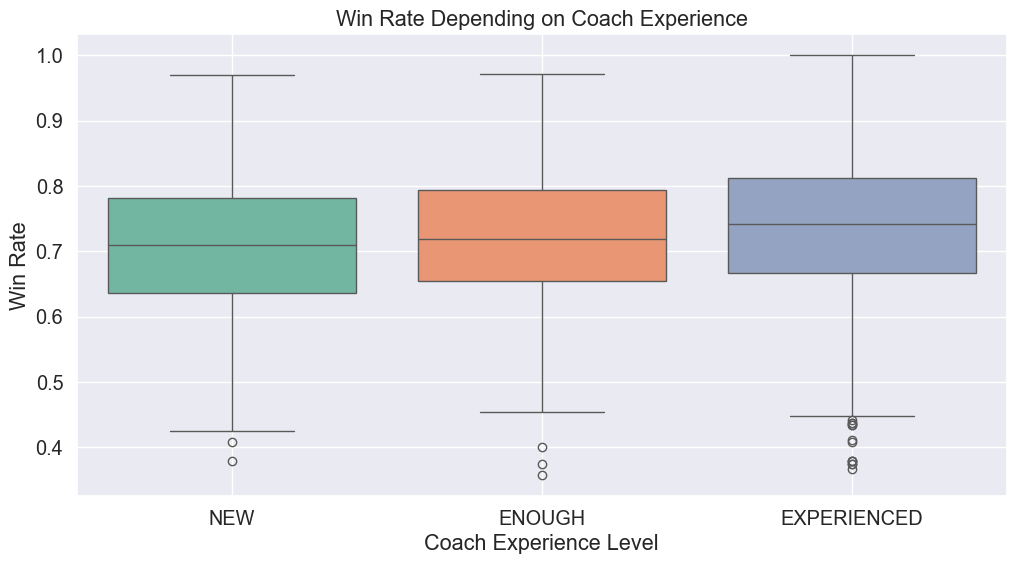

In [247]:
# Filter out rows with NaN values in 'ExperienceLevel' and 'WinRate'
filtered_data = teams_expanded_5.dropna(subset=['ExperienceLevel', 'WinRate'])

# Plot the win rate depending on coach experience
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='ExperienceLevel', y='WinRate', hue='ExperienceLevel')
plt.title('Win Rate Depending on Coach Experience')
plt.xlabel('Coach Experience Level')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

## Generation pairwise records for training and testing the model

In [248]:
m_tourney_results = pd.read_csv('data/MNCAATourneyCompactResults.csv')
w_tourney_results = pd.read_csv('data/WNCAATourneyCompactResults.csv')

tourney_results = pd.concat([m_tourney_results, w_tourney_results], axis=0)
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Add city data

In [249]:
cities = pd.read_csv('data/Cities.csv')
m_game_cities = pd.read_csv('data/MGameCities.csv')
w_game_cities = pd.read_csv('data/WGameCities.csv')

game_cities = pd.concat([m_game_cities, w_game_cities], axis=0)
game_cities = game_cities.merge(cities, on='CityID', how='left')    
game_cities.head()

,Season,DayNum,WTeamID,LTeamID,CRType,CityID,City,State
0,2010,7,1143,1293,Regular,4027,Berkeley,CA
1,2010,7,1314,1198,Regular,4061,Chapel Hill,NC
2,2010,7,1326,1108,Regular,4080,Columbus,OH
3,2010,7,1393,1107,Regular,4340,Syracuse,NY
4,2010,9,1143,1178,Regular,4027,Berkeley,CA


In [250]:
tourney_results = tourney_results.merge(game_cities, on=['Season', 'DayNum', 'WTeamID', 'LTeamID'], how='left')
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,CRType,CityID,City,State
0,1985,136,1116,63,1234,54,N,0,NaN,NaN,NaN,NaN
1,1985,136,1120,59,1345,58,N,0,NaN,NaN,NaN,NaN
2,1985,136,1207,68,1250,43,N,0,NaN,NaN,NaN,NaN
3,1985,136,1229,58,1425,55,N,0,NaN,NaN,NaN,NaN
4,1985,136,1242,49,1325,38,N,0,NaN,NaN,NaN,NaN


In [251]:
tourney_results.rename(columns={
    'WTeamID': 'TeamID_1',
    'WScore': 'Score_1',
    'LTeamID': 'TeamID_2',
    'LScore': 'Score_2'
}, inplace=True)

Lets switch 50% of the records so that the winning teams doesnt always go first

In [252]:
import random

# Randomly shuffle 50% of the rows
random.seed(42)
mask = random.sample(range(len(tourney_results)), len(tourney_results) // 2)
tourney_results.iloc[mask] = tourney_results.iloc[mask].apply(
    lambda row: pd.Series({
        'Season': row['Season'],
        'DayNum': row['DayNum'],
        'TeamID_1': row['TeamID_2'],
        'Score_1': row['Score_2'],
        'TeamID_2': row['TeamID_1'],
        'Score_2': row['Score_1'],
        'WLoc': row['WLoc'],
        'NumOT': row['NumOT'],
        'CRType': row['CRType'],
        'CityID': row['CityID'],
        'City': row['City'],
        'State': row['State']
    }), axis=1
)

In [253]:
tourney_results['target'] = (tourney_results['Score_1'] > tourney_results['Score_2']).astype(int)
tourney_results.sample(10)

,Season,DayNum,TeamID_1,Score_1,TeamID_2,Score_2,WLoc,NumOT,CRType,CityID,City,State,target
2342,2022,137,1261,54,1235,59,N,0,NCAA,4215.0,Milwaukee,WI,0
2197,2019,136,1285,55,1276,74,N,0,NCAA,4097.0,Des Moines,IA,0
135,1987,136,1323,84,1292,71,N,0,NaN,NaN,NaN,NaN,1
1158,2003,137,1122,64,1257,86,N,0,NaN,NaN,NaN,NaN,0
1505,2008,143,1397,60,1257,79,N,0,NaN,NaN,NaN,NaN,0
2609,1999,138,3111,54,3397,113,H,0,NaN,NaN,NaN,NaN,0
315,1990,136,1116,68,1343,64,N,0,NaN,NaN,NaN,NaN,1
2151,2018,137,1452,85,1293,68,N,0,NCAA,4303.0,San Diego,CA,1
1988,2016,136,1403,61,1139,71,N,0,NCAA,4287.0,Raleigh,NC,0
2541,1998,138,3235,79,3245,76,H,0,NaN,NaN,NaN,NaN,1


In [254]:
len(tourney_results)

4168

Join the team features

In [255]:
teams_expanded_5_1 = teams_expanded_5.add_suffix('_1')
teams_expanded_5_1.rename(columns={'Season_1': 'Season', 'TeamID_1': 'TeamID'}, inplace=True)

teams_expanded_5_2 = teams_expanded_5.add_suffix('_2')
teams_expanded_5_2.rename(columns={'Season_2': 'Season', 'TeamID_2': 'TeamID'}, inplace=True)

df = pd.merge(
    tourney_results,
    teams_expanded_5_1,
    left_on=['Season', 'TeamID_1'],
    right_on=['Season', 'TeamID'],
    how='left',
    suffixes=('', '_1')
)

df = pd.merge(
    df,
    teams_expanded_5_2,
    left_on=['Season', 'TeamID_2'],
    right_on=['Season', 'TeamID'],
    how='left',
    suffixes=('', '_2')
)
df.head()

,Season,DayNum,TeamID_1,Score_1,TeamID_2,Score_2,WLoc,NumOT,CRType,CityID,...,gender_2,AvgPointsDiff_2,WinRate_2,PublicRank_2,RankingSystem_2,ConfAbbrev_2,Description_2,Fired_During_Season_2,ConsecutiveYears_2,ExperienceLevel_2
0,1985,136,1116,63,1234,54,N,0,NaN,NaN,...,M,10.466667,0.666667,NaN,NaN,big_ten,Big Ten Conference,0.0,1.0,NEW
1,1985,136,1345,58,1120,59,N,0,NaN,NaN,...,M,3.689655,0.620690,NaN,NaN,sec,Southeastern Conference,0.0,1.0,NEW
2,1985,136,1250,43,1207,68,N,0,NaN,NaN,...,M,15.666667,0.925926,NaN,NaN,big_east,Big East Conference,0.0,1.0,NEW
3,1985,136,1229,58,1425,55,N,0,NaN,NaN,...,M,3.785714,0.678571,NaN,NaN,pac_ten,Pacific-10 Conference,0.0,1.0,NEW
4,1985,136,1325,38,1242,49,N,0,NaN,NaN,...,M,5.633333,0.766667,NaN,NaN,big_eight,Big Eight Conference,0.0,1.0,NEW


Lets only leave the columns that are useful for prediction or analysis

In [256]:
df.drop(columns=[
    'TeamID',
    'DayNum',
    'NumOT',
    'CRType',
    'CityID',
    'gender_2',
    'ConfAbbrev_1',
    'WLoc'
], inplace=True)

df.rename(columns={
    'gender_1': 'gender'
}, inplace=True)

In [257]:
df['seed_diff'] = df['Seed_num_1'] - df['Seed_num_2']
df['rank_diff'] = df['PublicRank_1'] - df['PublicRank_2']
df['win_rate_diff'] = df['WinRate_1'] - df['WinRate_2']
df['points_diff_diff'] = df['AvgPointsDiff_1'] - df['AvgPointsDiff_2']
df['consequtive_years_diff'] = df['ConsecutiveYears_1'] - df['ConsecutiveYears_2']

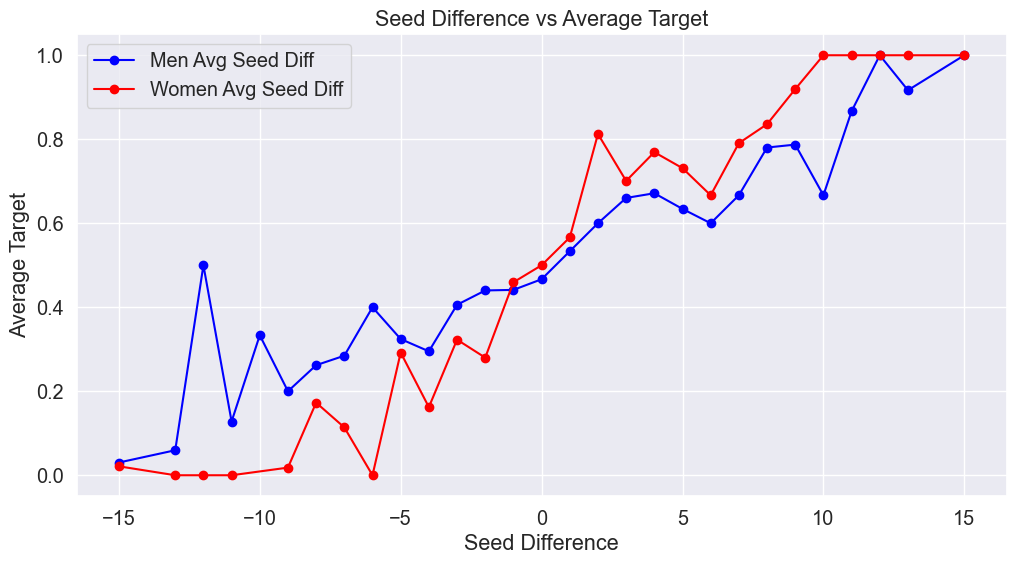

In [258]:
import seaborn as sns

import matplotlib.pyplot as plt

# Group by seed_diff and calculate the average target
grouped_df = df.groupby(by=['seed_diff', 'gender'])['target'].mean().reset_index()

# Create a boxplot for seed_diff vs average target

plt.figure(figsize=(12, 6))
plt.plot(-grouped_df.query("gender == 'M'")['seed_diff'], grouped_df.query("gender == 'M'")['target'], marker='o', linestyle='-', color='b', label='Men Avg Seed Diff')

plt.plot(-grouped_df.query("gender == 'W'")['seed_diff'], grouped_df.query("gender == 'W'")['target'], marker='o', linestyle='-', color='r', label='Women Avg Seed Diff')
plt.title('Seed Difference vs Average Target')
plt.legend()
plt.xlabel('Seed Difference')
plt.ylabel('Average Target')
plt.grid(True)
plt.show()


Lets add pairwise features corresponding to team features differences

## Model application

Lets define features we will use for the model

In [1]:
features = [
    'seed_diff',
    'rank_diff',
    'win_rate_diff',
    'points_diff_diff',
    'consequtive_years_diff',
    'Seed_num_1',
    'Seed_num_2',
    'PublicRank_1',
    'PublicRank_2',
    'WinRate_1',
    'WinRate_2',
    'AvgPointsDiff_1',
    'AvgPointsDiff_2',
    'ConsecutiveYears_1',
    'ConsecutiveYears_2',
    'gender',
    'Fired_During_Season_1',
    'Fired_During_Season_2',
    'ExperienceLevel_1',
    'ExperienceLevel_2'
]

target = 'target'

In [260]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

In [261]:
X = df[features]
y = df[target]
X['consequtive_years_diff'] = X['consequtive_years_diff'].fillna(0)
X['rank_diff'] = X['rank_diff'].fillna(0)
X['PublicRank_1'] = X['PublicRank_1'].fillna(15)
X['PublicRank_2'] = X['PublicRank_2'].fillna(15)
X['Fired_During_Season_1'] = X['Fired_During_Season_1'].fillna(0)
X['Fired_During_Season_2'] = X['Fired_During_Season_2'].fillna(0)
X['ExperienceLevel_1'] = X['ExperienceLevel_1'].fillna('EXPERIENCED')
X['ExperienceLevel_2'] = X['ExperienceLevel_2'].fillna('EXPERIENCED')
X['ConsecutiveYears_1'] = X['ConsecutiveYears_1'].fillna(0)
X['ConsecutiveYears_2'] = X['ConsecutiveYears_2'].fillna(0)

# manual label encoding for Experience level
X['ExperienceLevel_1'] = X['ExperienceLevel_1'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)
X['ExperienceLevel_2'] = X['ExperienceLevel_2'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)

# one hot encoding for gender
X['gender'] = OneHotEncoder(drop='first').fit_transform(X[['gender']]).toarray()

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/3719884632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['consequtive_years_diff'] = X['consequtive_years_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/3719884632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rank_diff'] = X['rank_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/3719884632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [262]:
def gen_time_iterator(n_splits=8):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    seasons = pd.Series(range(1985, 2025))
    myTimeiterator = []

    for train_index, test_index in tscv.split(seasons):
        train_seasons = seasons[train_index]
        test_seasons = seasons[test_index]
        
        train_indices = df[df['Season'].isin(train_seasons)].index
        test_indices = df[df['Season'].isin(test_seasons)].index

        myTimeiterator.append((train_indices, test_indices))
    
    return myTimeiterator


In [263]:
cv_results = cross_validate(
    RandomForestClassifier(
        random_state=42,
        n_estimators=300,
        min_samples_split=5,
        min_samples_leaf=15,
        max_features=0.3,
        max_depth=5
    ),
    X, y,
    cv=gen_time_iterator(n_splits=5),
    scoring=['neg_brier_score', 'accuracy'],
    return_train_score=True,
    verbose=1
)

# Print results
results_df = pd.DataFrame(cv_results)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [300, 500, 1000],            # Number of trees
#     'max_depth': [5, 7, 10, None],                 # Limit tree depth
#     'min_samples_split': [2, 5, 10, 20],              # Require more samples for splitting
#     'min_samples_leaf': [2, 4, 10, 15],                # More samples per leaf to generalize
#     'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8],  # Reduce correlation among trees
# }

# grid_search = RandomizedSearchCV(
#     n_iter=400,
#     estimator=RandomForestClassifier(random_state=42),
#     param_distributions=param_grid,
#     scoring='neg_brier_score',
#     cv=gen_time_iterator(n_splits=5),
#     n_jobs=-1,
#     verbose=3
# )

# grid_search.fit(X, y)

# # Best parameters after search:
# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validation accuracy:", grid_search.best_score_)

In [265]:
final_model = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=15,
    max_features=0.3,
    max_depth=5
)
final_model.fit(X, y)

RandomForestClassifier(max_depth=5, max_features=0.3, min_samples_leaf=15,
                       min_samples_split=5, n_estimators=300, random_state=42)

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/1364103695.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')


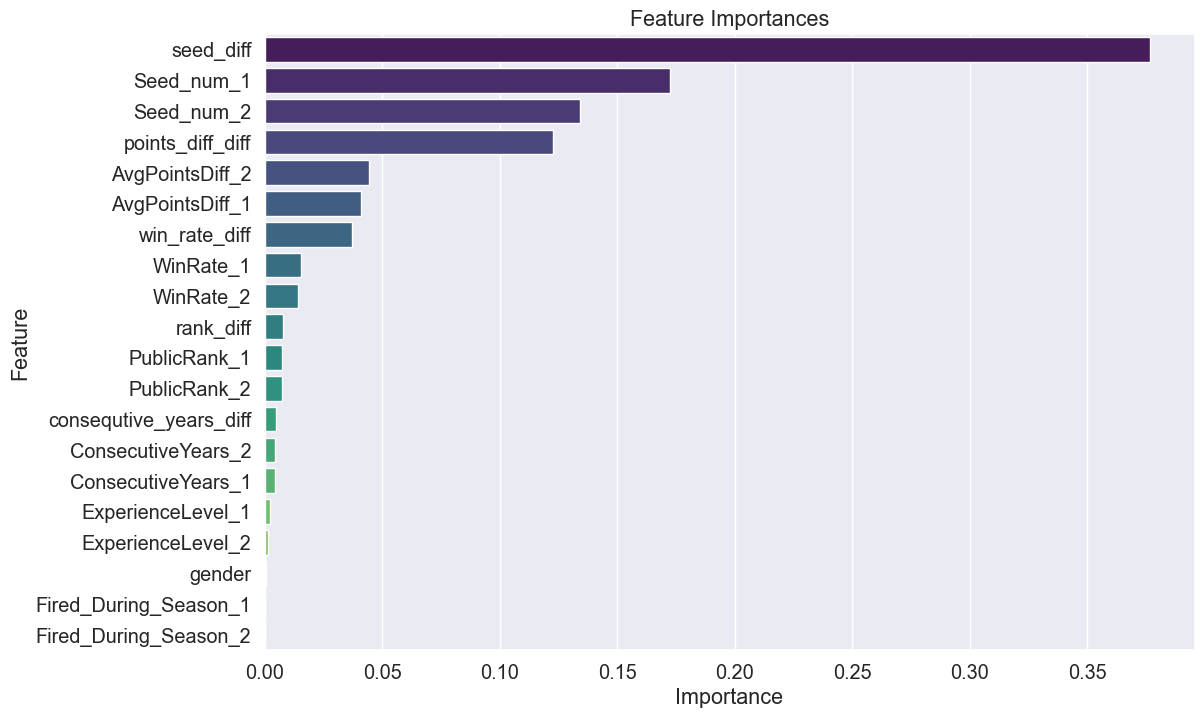

In [266]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [267]:
from sklearn.metrics import accuracy_score

In [268]:
def make_big(X, y):
    X_swapped = X.copy()

    # Swap the columns for team 1 and team 2
    for col in X.columns:
        if col.endswith('_1'):
            X_swapped[col] = X[col.replace('_1', '_2')]
        elif col.endswith('_2'):
            X_swapped[col] = X[col.replace('_2', '_1')]

    # Reverse the differences
    X_swapped['seed_diff'] = -X['seed_diff']
    X_swapped['rank_diff'] = -X['rank_diff']
    X_swapped['win_rate_diff'] = -X['win_rate_diff']
    X_swapped['points_diff_diff'] = -X['points_diff_diff']
    X_swapped['consequtive_years_diff'] = -X['consequtive_years_diff']

    y_swapped = y.copy()
    y_swapped = 1 - y_swapped

    # Concatenate the original and swapped datasets
    X_big = pd.concat([X, X_swapped], axis=0).reset_index(drop=True)
    y_big = pd.concat([y, y_swapped], axis=0).reset_index(drop=True)
    return X_big, y_big


In [269]:
def estimate_year_score(year):
    train_indices = df[(1985 <= df['Season']) & (df['Season'] <= year-1)].index
    test_indices = df[df['Season'] == year].index


    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    
    X_train, y_train = make_big(X_train, y_train)

    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    final_model = RandomForestClassifier(
        random_state=42,
        n_estimators=1000,
        min_samples_split=5,
        min_samples_leaf=15,
        max_features=0.3,
        max_depth=5
    )
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred > 0.5)
    return float(brier_score), accuracy

In [270]:
years = list(range(1986, 2020)) + list(range(2021, 2025))
brier_scores = []
accuracies = []

for year in years:
    if year == 2020:
        continue
    brier_score, accuracy = estimate_year_score(year)
    brier_scores.append(brier_score)
    accuracies.append(accuracy)

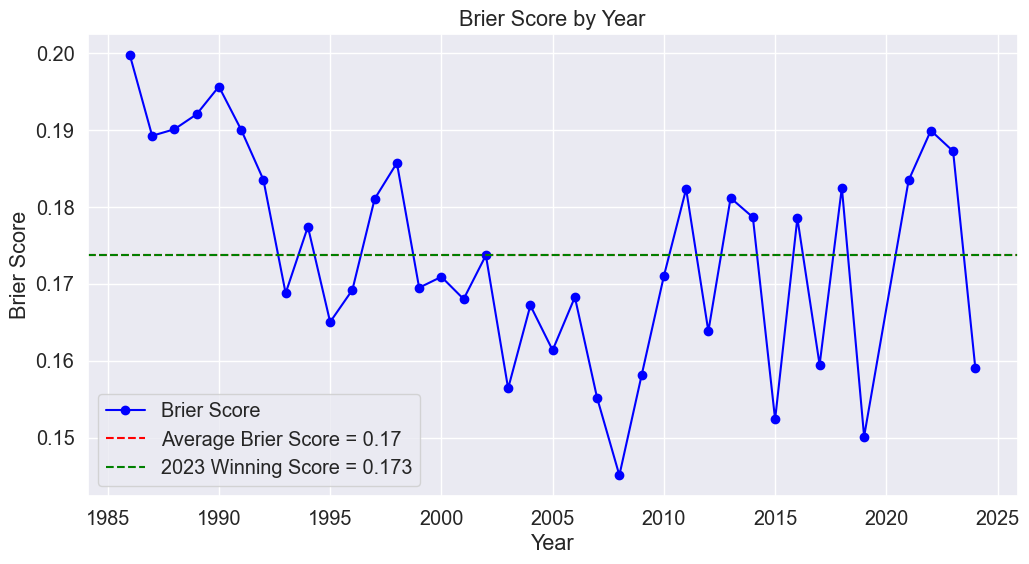

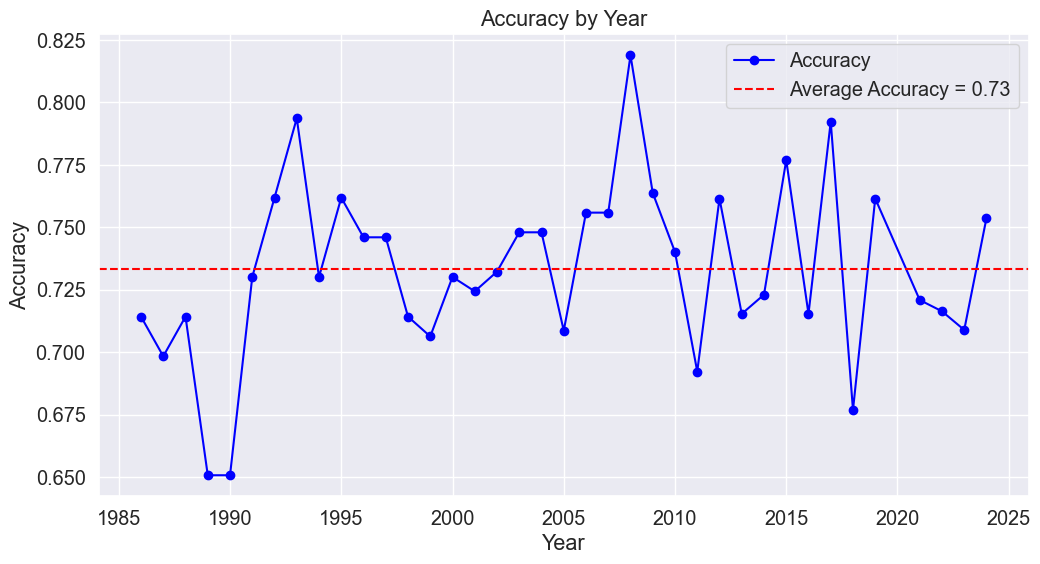

In [271]:
# Plot Brier scores
plt.figure(figsize=(12, 6))
plt.plot(years, brier_scores, marker='o', linestyle='-', color='b', label='Brier Score')
plt.axhline(y=np.mean(brier_scores), color='r', linestyle='--', label=f'Average Brier Score = {np.mean(brier_scores):.2f}')
plt.axhline(y=0.1737, color='g', linestyle='--', label='2023 Winning Score = 0.173')
plt.title('Brier Score by Year')
plt.xlabel('Year')
plt.ylabel('Brier Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 6))
plt.plot(years, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=np.mean(accuracies), color='r', linestyle='--', label=f'Average Accuracy = {np.mean(accuracies):.2f}')
plt.title('Accuracy by Year')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Submission

In [272]:
final_model = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=15,
    max_features=0.3,
    max_depth=5
)

X_big, y_big = make_big(X, y)
final_model.fit(X_big, y_big)

RandomForestClassifier(max_depth=5, max_features=0.3, min_samples_leaf=15,
                       min_samples_split=5, n_estimators=300, random_state=42)

### 2025 Prediction

In [273]:
submission_df = pd.read_csv('data/SampleSubmissionStage2.csv')

In [274]:
def extract_game_info(id_str):
    # Extract year and team_ids
    parts = id_str.split('_')
    year = int(parts[0])
    teamID1 = int(parts[1])
    teamID2 = int(parts[2])
    return year, teamID1, teamID2
submission_df[['Season', 'TeamID1', 'TeamID2']] = submission_df['ID'].apply(extract_game_info).tolist()

In [275]:
teams_2025 = teams_expanded_5.query('Season == 2025')
len(teams_2025)

136

In [276]:
submission_df = submission_df.merge(teams_2025, left_on='TeamID1', right_on='TeamID', how='left')
submission_df = submission_df.merge(teams_2025, left_on='TeamID2', right_on='TeamID', how='left', suffixes=('_1', '_2'))

In [277]:
submission_df['realistic_flg'] = (~submission_df['TeamID_1'].isna()) & (~submission_df['TeamID_2'].isna()) & (submission_df['gender_1'] == submission_df['gender_2'])

In [278]:
submission_df['seed_diff'] = submission_df['Seed_num_1'] - submission_df['Seed_num_2']
submission_df['rank_diff'] = submission_df['PublicRank_1'] - submission_df['PublicRank_2']
submission_df['win_rate_diff'] = submission_df['WinRate_1'] - submission_df['WinRate_2']
submission_df['points_diff_diff'] = submission_df['AvgPointsDiff_1'] - submission_df['AvgPointsDiff_2']
submission_df['consequtive_years_diff'] = submission_df['ConsecutiveYears_1'] - submission_df['ConsecutiveYears_2']
submission_df['gender'] = submission_df['gender_1']

In [279]:
realistic_submission_df = submission_df[submission_df['realistic_flg']]
X = realistic_submission_df[features]
X['consequtive_years_diff'] = X['consequtive_years_diff'].fillna(0)
X['rank_diff'] = X['rank_diff'].fillna(0)
X['PublicRank_1'] = X['PublicRank_1'].fillna(15)
X['PublicRank_2'] = X['PublicRank_2'].fillna(15)
X['Fired_During_Season_1'] = X['Fired_During_Season_1'].fillna(0)
X['Fired_During_Season_2'] = X['Fired_During_Season_2'].fillna(0)
X['ExperienceLevel_1'] = X['ExperienceLevel_1'].fillna('EXPERIENCED')
X['ExperienceLevel_2'] = X['ExperienceLevel_2'].fillna('EXPERIENCED')
X['ConsecutiveYears_1'] = X['ConsecutiveYears_1'].fillna(0)
X['ConsecutiveYears_2'] = X['ConsecutiveYears_2'].fillna(0)

# manual label encoding for Experience level
X['ExperienceLevel_1'] = X['ExperienceLevel_1'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)
X['ExperienceLevel_2'] = X['ExperienceLevel_2'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)

# one hot encoding for gender
X['gender'] = OneHotEncoder(drop='first').fit_transform(X[['gender']]).toarray()

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/610432089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['consequtive_years_diff'] = X['consequtive_years_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/610432089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rank_diff'] = X['rank_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/610432089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [280]:
realistic_submission_df['model_pred'] = final_model.predict_proba(X)[:, 1]

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/1268556444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  realistic_submission_df['model_pred'] = final_model.predict_proba(X)[:, 1]


In [281]:
realistic_submission_df = realistic_submission_df[['TeamID_1', 'TeamID_2', 'model_pred']]

In [282]:
submission_df = submission_df.merge(realistic_submission_df, left_on=['TeamID1', 'TeamID2'], right_on=['TeamID_1', 'TeamID_2'], how='left')

In [283]:
submission_df

,ID,Pred,Season_x,TeamID1,TeamID2,Season_y,Seed_1,TeamID_1_x,Region_1,Seed_num_1,...,realistic_flg,seed_diff,rank_diff,win_rate_diff,points_diff_diff,consequtive_years_diff,gender,TeamID_1_y,TeamID_2_y,model_pred
0,2025_1101_1102,0.5,2025,1101,1102,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025_1101_1103,0.5,2025,1101,1103,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025_1101_1104,0.5,2025,1101,1104,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025_1101_1105,0.5,2025,1101,1105,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025_1101_1106,0.5,2025,1101,1106,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131402,2025_3477_3479,0.5,2025,3477,3479,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131403,2025_3477_3480,0.5,2025,3477,3480,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131404,2025_3478_3479,0.5,2025,3478,3479,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131405,2025_3478_3480,0.5,2025,3478,3480,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
submission_df['Pred'] = submission_df.apply(
    lambda row: row['model_pred'] if row['realistic_flg'] else row['Pred'],
    axis=1
)

In [285]:
submission_df = submission_df[['ID', 'Pred']]

In [286]:
submission_df.to_csv('submission.csv', index=False)

In [287]:
from itertools import product

# Filter teams for the 2025 season
teams_2025 = teams_expanded_5.query('(Season == 2025) & gender == "M"')

# Generate all possible pairs of teams
team_pairs = pd.DataFrame(list(product(teams_2025['TeamID'], repeat=2)), columns=['TeamID_1', 'TeamID_2'])

# Remove pairs where both teams are the same
# team_pairs = team_pairs[team_pairs['TeamID_1'] != team_pairs['TeamID_2']]

# Add the season column
team_pairs['Season'] = 2025

# Merge team features for both teams in the pair
team_pairs = team_pairs.merge(teams_2025.add_suffix('_1'), left_on=['TeamID_1'], right_on=['TeamID_1'])
team_pairs = team_pairs.merge(teams_2025.add_suffix('_2'), left_on=['TeamID_2'], right_on=['TeamID_2'])

# Calculate pairwise features
team_pairs['seed_diff'] = team_pairs['Seed_num_1'] - team_pairs['Seed_num_2']
team_pairs['rank_diff'] = team_pairs['PublicRank_1'] - team_pairs['PublicRank_2']
team_pairs['win_rate_diff'] = team_pairs['WinRate_1'] - team_pairs['WinRate_2']
team_pairs['points_diff_diff'] = team_pairs['AvgPointsDiff_1'] - team_pairs['AvgPointsDiff_2']
team_pairs['consequtive_years_diff'] = team_pairs['ConsecutiveYears_1'] - team_pairs['ConsecutiveYears_2']

# Display the first few rows of the generated pairs
team_pairs.head()

,TeamID_1,TeamID_2,Season,Season_1,Seed_1,Region_1,Seed_num_1,TeamName_1,FirstD1Season_1,LastD1Season_1,...,ConfAbbrev_2,Description_2,Fired_During_Season_2,ConsecutiveYears_2,ExperienceLevel_2,seed_diff,rank_diff,win_rate_diff,points_diff_diff,consequtive_years_diff
0,1181,1181,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,acc,Atlantic Coast Conference,0.0,3.0,ENOUGH,0,0.0,0.000000,0.000000,0.0
1,1181,1104,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,sec,Southeastern Conference,0.0,6.0,EXPERIENCED,-1,-4.0,0.154189,11.097148,-3.0
2,1181,1458,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,big_ten,Big Ten Conference,0.0,10.0,EXPERIENCED,-2,-18.0,0.168908,11.508403,-7.0
3,1181,1112,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,big_twelve,Big 12 Conference,0.0,4.0,ENOUGH,-3,-16.0,0.264706,11.500000,-1.0
4,1181,1332,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,big_ten,Big Ten Conference,0.0,15.0,EXPERIENCED,-4,-33.0,0.184492,15.521390,-12.0


In [288]:
team_pairs['gender'] = 'M'
team_pairs['seed_diff'] = team_pairs['Seed_num_1'] - team_pairs['Seed_num_2']
team_pairs['rank_diff'] = team_pairs['PublicRank_1'] - team_pairs['PublicRank_2']
team_pairs['win_rate_diff'] = team_pairs['WinRate_1'] - team_pairs['WinRate_2']
team_pairs['points_diff_diff'] = team_pairs['AvgPointsDiff_1'] - team_pairs['AvgPointsDiff_2']
team_pairs['consequtive_years_diff'] = team_pairs['ConsecutiveYears_1'] - team_pairs['ConsecutiveYears_2']

In [289]:
X_2025 = team_pairs[features]
X_2025['consequtive_years_diff'] = X_2025['consequtive_years_diff'].fillna(0)
X_2025['rank_diff'] = X_2025['rank_diff'].fillna(0)
X_2025['PublicRank_1'] = X_2025['PublicRank_1'].fillna(15)
X_2025['PublicRank_2'] = X_2025['PublicRank_2'].fillna(15)
X_2025['Fired_During_Season_1'] = X_2025['Fired_During_Season_1'].fillna(0)
X_2025['Fired_During_Season_2'] = X_2025['Fired_During_Season_2'].fillna(0)
X_2025['ExperienceLevel_1'] = X_2025['ExperienceLevel_1'].fillna('EXPERIENCED')
X_2025['ExperienceLevel_2'] = X_2025['ExperienceLevel_2'].fillna('EXPERIENCED')
X_2025['ConsecutiveYears_1'] = X_2025['ConsecutiveYears_1'].fillna(0)
X_2025['ConsecutiveYears_2'] = X_2025['ConsecutiveYears_2'].fillna(0)

# manual label encoding for Experience level
X_2025['ExperienceLevel_1'] = X_2025['ExperienceLevel_1'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)
X_2025['ExperienceLevel_2'] = X_2025['ExperienceLevel_2'].map({'NEW': 0, 'ENOUGH': 1, 'EXPERIENCED': 2}).astype(int)

# one hot encoding for gender
# X_2025['gender'] = OneHotEncoder(drop='first').fit_transform(X_2025[['gender']]).toarray()
X_2025['gender'] = 1

/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/2004981220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2025['consequtive_years_diff'] = X_2025['consequtive_years_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/2004981220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2025['rank_diff'] = X_2025['rank_diff'].fillna(0)
/var/folders/8v/bx_f_4bj0klchryrhdgxty9h0000gn/T/ipykernel_32583/2004981220.py:4: SettingWithCopyWarning: 
A value is trying t

In [290]:
y_pred = final_model.predict_proba(X_2025)[:, 1]
team_pairs['pred'] = y_pred 

In [291]:
team_pairs_same_region = team_pairs.query('Region_1 == Region_2')

In [292]:
team_pairs_same_region

,TeamID_1,TeamID_2,Season,Season_1,Seed_1,Region_1,Seed_num_1,TeamName_1,FirstD1Season_1,LastD1Season_1,...,Fired_During_Season_2,ConsecutiveYears_2,ExperienceLevel_2,seed_diff,rank_diff,win_rate_diff,points_diff_diff,consequtive_years_diff,gender,pred
0,1181,1181,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,0.0,3.0,ENOUGH,0,0.0,0.000000,0.000000,0.0,M,0.493380
1,1181,1104,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,0.0,6.0,EXPERIENCED,-1,-4.0,0.154189,11.097148,-3.0,M,0.724812
2,1181,1458,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,0.0,10.0,EXPERIENCED,-2,-18.0,0.168908,11.508403,-7.0,M,0.794087
3,1181,1112,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,0.0,4.0,ENOUGH,-3,-16.0,0.264706,11.500000,-1.0,M,0.827626
4,1181,1332,2025,2025,W01,W,1,Duke,1985.0,2025.0,...,0.0,15.0,EXPERIENCED,-4,-33.0,0.184492,15.521390,-12.0,M,0.822058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,1313,1161,2025,2025,Z16,Z,16,Norfolk St,1998.0,2025.0,...,0.0,7.0,EXPERIENCED,4,130.0,-0.057875,-4.276091,5.0,M,0.332403
4620,1313,1213,2025,2025,Z16,Z,16,Norfolk St,1998.0,2025.0,...,0.0,5.0,EXPERIENCED,3,85.0,-0.103831,-4.972782,7.0,M,0.366056
4621,1313,1423,2025,2025,Z16,Z,16,Norfolk St,1998.0,2025.0,...,0.0,5.0,EXPERIENCED,2,63.0,-0.103831,-2.941532,7.0,M,0.408612
4622,1313,1303,2025,2025,Z16,Z,16,Norfolk St,1998.0,2025.0,...,0.0,3.0,ENOUGH,1,30.0,0.052419,2.089718,9.0,M,0.442474


In [293]:
# Plot the predicted probabilities

team_pairs['Opponent and Seed'] = team_pairs_same_region['TeamName_2'] + ' (' + team_pairs_same_region['Seed_num_2'].astype(str) + ')'

plt.figure(figsize=(8, 6))
sns.barplot(data=team_pairs_same_region.sort_values(by='pred', ascending=False), y='Opponent and Seed', x='pred', palette=sns.color_palette("RdYlGn_r", n_colors=team_pairs_same_region.shape[0]))
plt.title('Predicted Probabilities for Oregon vs Opponents')
plt.ylabel('Opponent Team')
plt.xlabel('Predicted Probability for Oregon')
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Probability')
plt.legend()
plt.show()

ValueError: Could not interpret value `Opponent and Seed` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

The sample_submission.csv file contains an "ID" column with the format year_teamID1_teamID2.

In [ ]:
submission_df.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [295]:
!pip3 install bracketeer

  Using cached bracketeer-0.2.0.tar.gz (40 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "/Users/danila6231/Documents/Uni/cs670/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/Users/danila6231/Documents/Uni/cs670/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
        File "/Users/danila6231/Documents/Uni/cs670/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 143, in get_requires_for_build_wheel
          return hook(config_settings)
        File "/private/var/folders/8v/bx_

In [ ]:
from bracketeer import build_bracket

path_to_NCAA_abs = '/kaggle/input/march-machine-learning-mania-2025/'
path_to_sub = '/kaggle/input/v3/submission_seed_adj.csv'

b = build_bracket(
outputPath='men_seed.png',
teamsPath=path_to_NCAA_abs+'MTeams.csv',
seedsPath=path_to_NCAA_abs+'MNCAATourneySeeds.csv',
submissionPath=path_to_sub,
slotsPath=path_to_NCAA_abs+'MNCAATourneySlots.csv',
year=2025
)